In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
import sklearn.model_selection as skm 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

**DANE**

In [3]:
#ramki danych do licencjata
import os

folder_path = "C:/Users/Nitro/Desktop/rzeczy na studia/licencjat/zbiorydanychLIC"

csv_data_list = []

#zgranie wszystkich plików csv z folderu do listy
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        csv_data_list.append(pd.read_csv(file_path))
        
#zmiana nazwy kolumny class na Class
for idx, i in enumerate(csv_data_list):
    if "class" in i.columns:
        csv_data_list[idx] = i.rename(columns={"class": "Class"})
#rozbicie listy na macierz, gdzie każdy wiersz to zbiór danych a kolumny to metoda preprocessingu
M = [[] for _ in range(1,11)]
k = 0
for j in range(len(M)):
    for i in range(1,36):
        M[j].append(csv_data_list[k])
        k += 1 

In [4]:
#tworzenie listy z nazwami plików csv
paths = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        paths.append(file_name)

#tworzenie listy z nazwami zbiorów danych
names = []
for i in range(0, len(paths), 35):
    s_cut = paths[i].split('_removal')[0]
    names.append(s_cut)

#tworzenie listy z nazwami strategii
strategie = []
for i in range(0, 35):
    s_cut = ("removal" + paths[i].split('_removal')[1]).removesuffix('.csv')
    strategie.append(s_cut)

In [5]:
index_basic = strategie.index('removal_min_median-other_none') + 1 

In [ ]:
#sprwadzenie czy wszędzie są te same strategie

#for i in range(10):
#    for j in range(35):
#        if ("removal" + paths[35*i+j].split('_removal')[1]).removesuffix('.csv') != strategie[j]:
#            print(35*i+j,i, j, "removal" + paths[i+j].split('_removal')[1])

#brak outputów, więc wszystko jest ok

**Modele, najpierw RandomSearch potem Default**

*RandomSearch*

In [ ]:
#test agregacji wyników w jeden csv
data = M[0][0]
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327200)

randsearch = skm.RandomizedSearchCV(ExtraTreesClassifier(random_state=327200),
                                    {'n_estimators': [100, 200, 300, 400, 500],
                                    'max_depth': [None, 20, 40, 60, 80, 100],
                                    'min_samples_split': [2, 5, 10],
                                    'max_features': ['sqrt', 'log2'],
                                    'criterion': ['gini', 'entropy'],},
                                    n_iter = 20,
                                    scoring = 'roc_auc',
                                    cv = skm.KFold(5, random_state=327200, shuffle=True))
model = randsearch.fit(X_train, y_train)

data = M[0][1]
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327200)

randsearch = skm.RandomizedSearchCV(ExtraTreesClassifier(random_state=327200),
                                    {'n_estimators': [100, 200, 300, 400, 500],
                                    'max_depth': [None, 20, 40, 60, 80, 100],
                                    'min_samples_split': [2, 5, 10],
                                    'max_features': ['sqrt', 'log2'],
                                    'criterion': ['gini', 'entropy'],},
                                    n_iter = 20,
                                    scoring = 'roc_auc',
                                    cv = skm.KFold(5, random_state=327200, shuffle=True))
model2 = randsearch.fit(X_train, y_train)

#zapis wyników do csv
df = pd.DataFrame(model.cv_results_)
df = df.drop(columns=["params"])
df.to_csv("wyniki_z_jednego_dataframe'a.csv")

df2 = pd.DataFrame(model2.cv_results_)
df2 = df2.drop(columns=["params"])
df2.to_csv("wyniki_z_drugiego_dataframe'a.csv")

#dopisanie nazw zbiorów danych i strategii do wyników
df["Dataset"] = names[0]
df2["Dataset"] = names[0]
df["Strategia"] = strategie[0]
df2["Strategia"] = strategie[1]

#złączenie dataframe'ów
df = pd.concat([df, df2], ignore_index=True, axis=0)

In [ ]:
#RANDOMSEARCH

for i in range(10):
    for j in range(35): #tu może będzie więcej, jeśli zaginione zbiory się znajdą
        #prep
        M[i][j] = pd.get_dummies(M[i][j], dtype = 'int64')
        X = M[i][j].drop('Class', axis=1)
        y = M[i][j].Class
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 327200)
        
        #randomsearch
        randsearch = skm.RandomizedSearchCV(ExtraTreesClassifier(random_state=327200),
                                            {'n_estimators': [100, 200, 300, 400, 500],
                                            'max_depth': [None, 20, 40, 60, 80, 100],
                                            'min_samples_split': [2, 5, 10],
                                            'max_features': ['sqrt', 'log2'],
                                            'criterion': ['gini', 'entropy'],},
                                            n_iter = 20,
                                            scoring = 'roc_auc',
                                            cv = skm.KFold(5, random_state=327200, shuffle=True))
        model = randsearch.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1] #nie wiem czy to się przyda
        roc_auc = roc_auc_score(y_test, y_pred_proba)    #nie wiem czy to się przyda
        
        #obsługa dataframe'ów
        df = pd.DataFrame(model.cv_results_)
        df = df.drop(columns=["params"])    
        df["Dataset"] = names[i]
        df["Strategia"] = strategie[j]

        #łączenie dataframe'ów
        if i == 0 and j == 0:
            dffinal = df
        else:
            dffinal = pd.concat([dffinal, df], ignore_index=True, axis=0)

#zapisanie wyników do csv        
dffinal.to_csv("wyniki.csv")

In [ ]:
#poprzednia komórka liczyła się 360 minut XD

*Default*

In [ ]:
wynikitrainmodel = [[] for _ in range(1,11)]
wynikitestmodel = [[] for _ in range(1,11)]
for i in range(len(M)):
    for j in range(len(M[0])):
        M[i][j] = pd.get_dummies(M[i][j], dtype = 'int64')
        X = M[i][j].drop('Class', axis=1)
        y = M[i][j].Class
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 327200)
        model = ExtraTreesClassifier(random_state=327200)
        kfold = skm.KFold(5, shuffle=True)
        wynikitrainmodel[i].append(round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = "roc_auc").mean(), 3))
        model = model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        wynikitestmodel[i].append(round(roc_auc, 6))

In [ ]:
wynikitrainmodel = np.array(wynikitrainmodel)
wynikitestmodel = np.array(wynikitestmodel)

wynikitestmodel = pd.DataFrame(wynikitestmodel)

wyniki trening: 

[[0.998 0.999 0.998 0.999 0.998 0.998 0.999 0.996 0.997 0.997 0.997 0.998
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.668 0.666 0.676 0.666 0.704 0.682 0.665 0.681 0.68  0.702 0.711 0.703
  0.674 0.672 0.672 0.65  0.669 0.651 0.672 0.656 0.643 0.64  0.666 0.703
  0.668 0.652 0.687 0.671 0.669 0.659 0.673 0.657 0.66  0.668 0.668]
 [0.993 0.993 0.992 0.992 0.992 0.99  0.993 0.993 0.991 0.991 0.991 0.992
  0.994 0.994 0.991 0.992 0.994 0.992 0.994 0.991 0.993 0.991 0.992 0.994
  0.994 0.994 0.995 0.994 0.994 0.991 0.993 0.99  0.993 0.994 0.993]
 [0.915 0.912 0.904 0.914 0.918 0.914 0.908 0.911 0.909 0.897 0.908 0.913
  0.911 0.913 0.914 0.911 0.921 0.914 0.909 0.908 0.91  0.911 0.902 0.903
  0.912 0.928 0.913 0.906 0.91  0.905 0.91  0.906 0.919 0.907 0.911]
 [0.779 0.752 0.796 0.751 0.706 0.751 0.754 0.774 0.699 0.773 0.779 0.785
  0.77  0.764 0.793 0.731 0.72  0.773 0.776

In [24]:
meanformethodtestmodel = []
for i in range(len(M[0])):
    l = []
    for j in range(0,10):
        l.append(wynikitestmodel[j][i])
    meanformethodtestmodel.append(round(np.mean(l),3))
print("średnie wyniki dla danych metod: \n", meanformethodtestmodel)
print("najlepszy średni wynik: \n", max(meanformethodtestmodel))
print("metoda z najlepszym wynikiem: \n", meanformethodtestmodel.index(max(meanformethodtestmodel)))
print("odchylenie standardowe średnich wyników różnych metod: \n", np.std(meanformethodtestmodel))

średnie wyniki dla danych metod: 
 [0.872, 0.867, 0.875, 0.869, 0.866, 0.87, 0.87, 0.871, 0.862, 0.871, 0.864, 0.871, 0.871, 0.86, 0.872, 0.87, 0.865, 0.868, 0.871, 0.871, 0.862, 0.871, 0.871, 0.863, 0.871, 0.861, 0.867, 0.869, 0.869, 0.865, 0.869, 0.861, 0.872, 0.861, 0.869]
najlepszy średni wynik: 
 0.875
metoda z najlepszym wynikiem: 
 2
odchylenie standardowe średnich wyników różnych metod: 
 0.003937885063776015


In [15]:
#zapisanie wyników do pliku csv 
wynikitestmodel.to_csv("wyniki_model.csv", index = False)

**Wizualizacja**

In [6]:
wynikiRS = pd.read_csv('wyniki.csv')
wynikitestmodel = pd.read_csv('wyniki_model.csv')

In [7]:
#poprawa nazw kolumn i wierszy
wynikitestmodel.columns = range(1,36)
wynikitestmodel.index = range(1,11)

In [ ]:
#czy to jest dobrze zrobione? Bo jest zabawa indeksami i wolę się upewnić 
mean_results = []
for i in range(10): #tyle jest zbi0rów
    strats = []
    for j in range(35): #tyle jest strategii
        mean_test_score = wynikiRS["mean_test_score"][700*i+20*j : 700*i+20*j+20].mean() #średnia z wyników 20 iteracji RS jako slice z dataframe'a
        strats.append(mean_test_score)
    mean_results.append(strats)

mean_results = pd.DataFrame(mean_results)
mean_results.columns = range(1,36) #zmiana nazw kolumn na liczby od 1 do 35, na potrzeby przejrzystości wykresów. W samej pracy opiszę która strategia ma jaki numer
mean_results.index = range(1,11) #zmiana nazw wierszy na liczby od 1 do 10, podobnie jak wyżej
mean_results

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
1,0.997857,0.997791,0.997824,0.997806,0.997774,0.997635,0.997637,0.997652,0.997691,0.997742,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.714768,0.724831,0.724761,0.719487,0.723712,0.727378,0.726650,0.719726,0.726492,0.722469,...,0.697806,0.710025,0.711913,0.702029,0.704206,0.707160,0.706769,0.710477,0.706533,0.705949
3,0.993571,0.993508,0.993576,0.994600,0.994564,0.994587,0.994528,0.994599,0.994507,0.994551,...,0.992139,0.992128,0.991959,0.991796,0.992114,0.992191,0.992162,0.990831,0.990913,0.990831
4,0.917417,0.915138,0.915075,0.912903,0.912076,0.913257,0.915021,0.911628,0.911855,0.913609,...,0.917521,0.912972,0.915706,0.914647,0.918282,0.911597,0.915351,0.920324,0.922008,0.919067
5,0.766585,0.744385,0.777562,0.746411,0.729379,0.764436,0.750144,0.763366,0.717418,0.763449,...,0.727538,0.763006,0.748490,0.758864,0.739235,0.760239,0.737688,0.753285,0.721495,0.768949
6,0.744690,0.722141,0.760354,0.745461,0.729888,0.760479,0.744886,0.758410,0.744619,0.758047,...,0.721388,0.758604,0.746236,0.759832,0.738463,0.759908,0.735886,0.744985,0.731428,0.758285
7,0.827154,0.826970,0.827099,0.826238,0.825301,0.826687,0.827871,0.825948,0.827405,0.826054,...,0.826506,0.824626,0.824266,0.827716,0.827273,0.828176,0.826712,0.829239,0.826255,0.825105
8,0.997960,0.986979,0.998042,0.998237,0.987027,0.998361,0.997729,0.997925,0.986991,0.998191,...,0.986141,0.998714,0.998602,0.998778,0.986127,0.998664,0.990206,0.998602,0.986165,0.998681
9,0.963331,0.961653,0.961511,0.948270,0.947106,0.948075,0.948131,0.948553,0.948525,0.947934,...,0.938550,0.939284,0.946146,0.940622,0.939362,0.940060,0.940621,0.943392,0.936673,0.935769
10,0.959555,0.958310,0.957683,0.961002,0.960671,0.959581,0.959265,0.959522,0.959662,0.957923,...,0.960862,0.959975,0.958302,0.958350,0.960441,0.960835,0.960039,0.959735,0.959609,0.960047


In [7]:
mean_results.to_csv("mean_results.csv", index = False) #zapisanie wyników do pliku csv

NameError: name 'mean_results' is not defined

In [8]:
mean_results = pd.read_csv('mean_results.csv')
mean_results.columns = range(1,36) #zmiana nazw kolumn na liczby od 1 do 35, na potrzeby przejrzystości wykresów. W samej pracy opiszę która strategia ma jaki numer
mean_results.index = range(1,11) #zmiana nazw wierszy na liczby od 1 do 10, podobnie jak wyżej

*Boxplot zbiorczy: x = metoda, y = ROCAUC z metody*

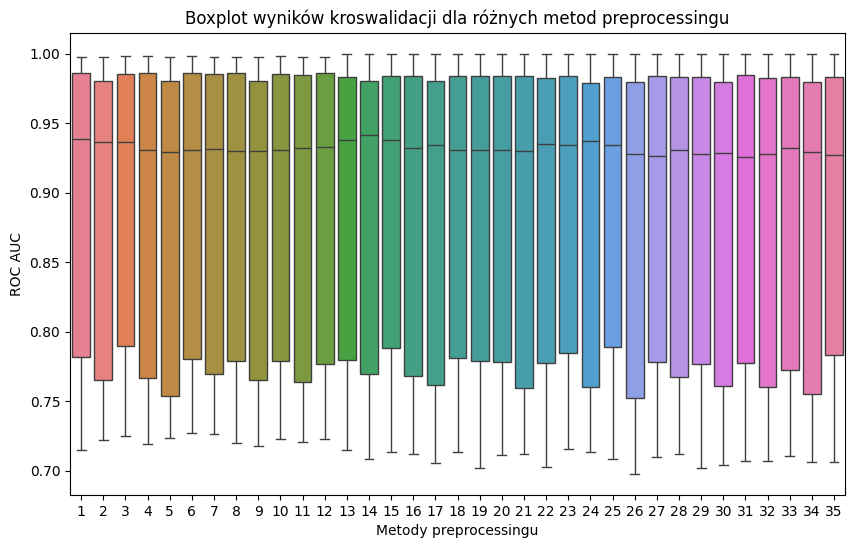

In [ ]:
#RadnomizedSearchCV
plt.figure(figsize=(10, 6))
sns.boxplot(data=mean_results)
plt.title("Boxplot wyników kroswalidacji dla różnych metod preprocessingu")
plt.xlabel("Metody preprocessingu")
plt.ylabel("ROC AUC")
plt.show()

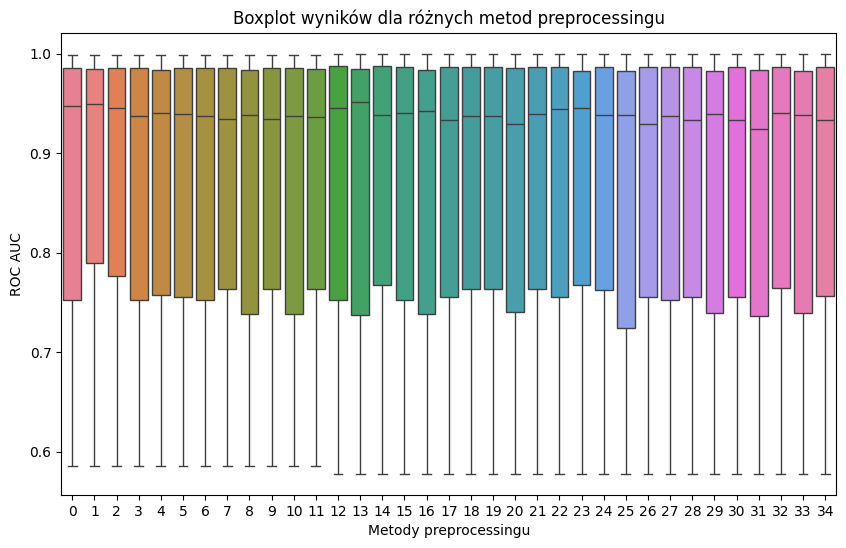

In [ ]:
#default
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitestmodel)
plt.title("Boxplot wyników dla różnych metod preprocessingu")
plt.xlabel("Metody preprocessingu")
plt.ylabel("ROC AUC")
plt.show()

*Boxplot zbiorczy: x = zbiór, y = ROCAUC*

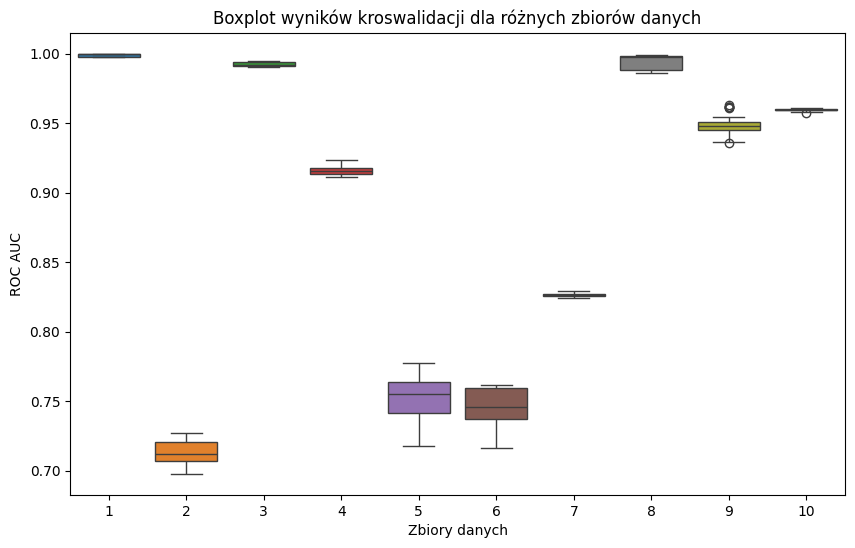

In [50]:
#RandomizedSearchCV
plt.figure(figsize=(10, 6))
sns.boxplot(data=mean_results.T)
plt.title("Boxplot wyników kroswalidacji dla różnych zbiorów danych")
plt.xlabel("Zbiory danych")
plt.ylabel("ROC AUC")
plt.show()

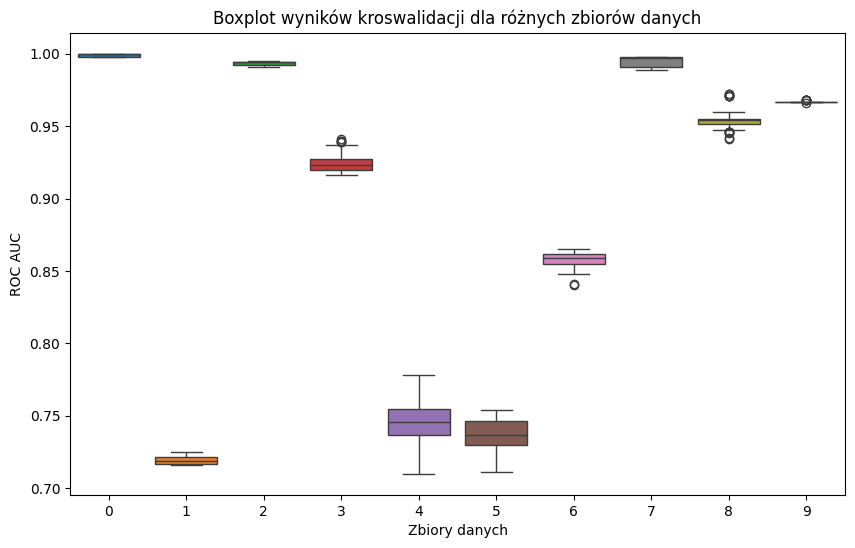

In [ ]:
#stare dane
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikiSTARE.T)
plt.title("Boxplot wyników kroswalidacji dla różnych zbiorów danych")
plt.xlabel("Zbiory danych")
plt.ylabel("ROC AUC")
plt.show()

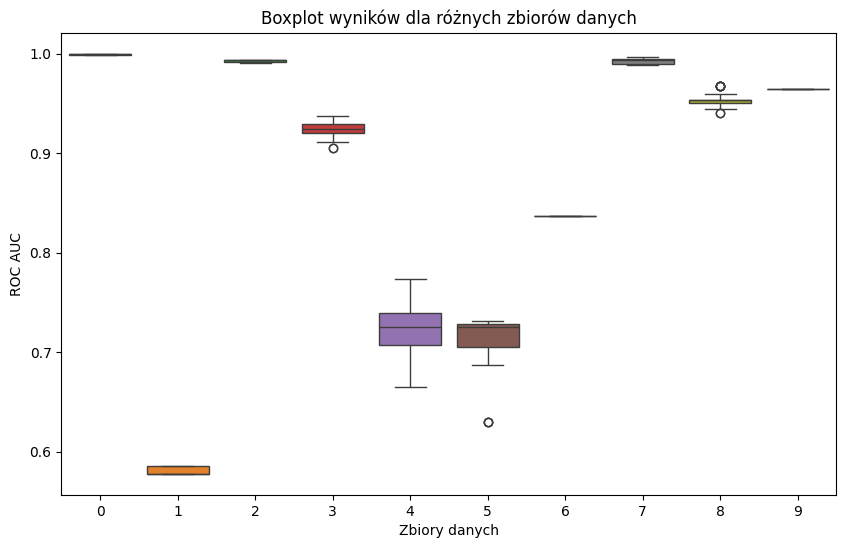

In [41]:
#default
plt.figure(figsize=(10, 6))
sns.boxplot(data=wynikitestmodel.T)
plt.title("Boxplot wyników dla różnych zbiorów danych")
plt.xlabel("Zbiory danych")
plt.ylabel("ROC AUC")
plt.show()

*Wykresy ROCAUC dla każdego zbioru danych, x = metoda, y = ROCAUC, wykres = zbiór danych* 

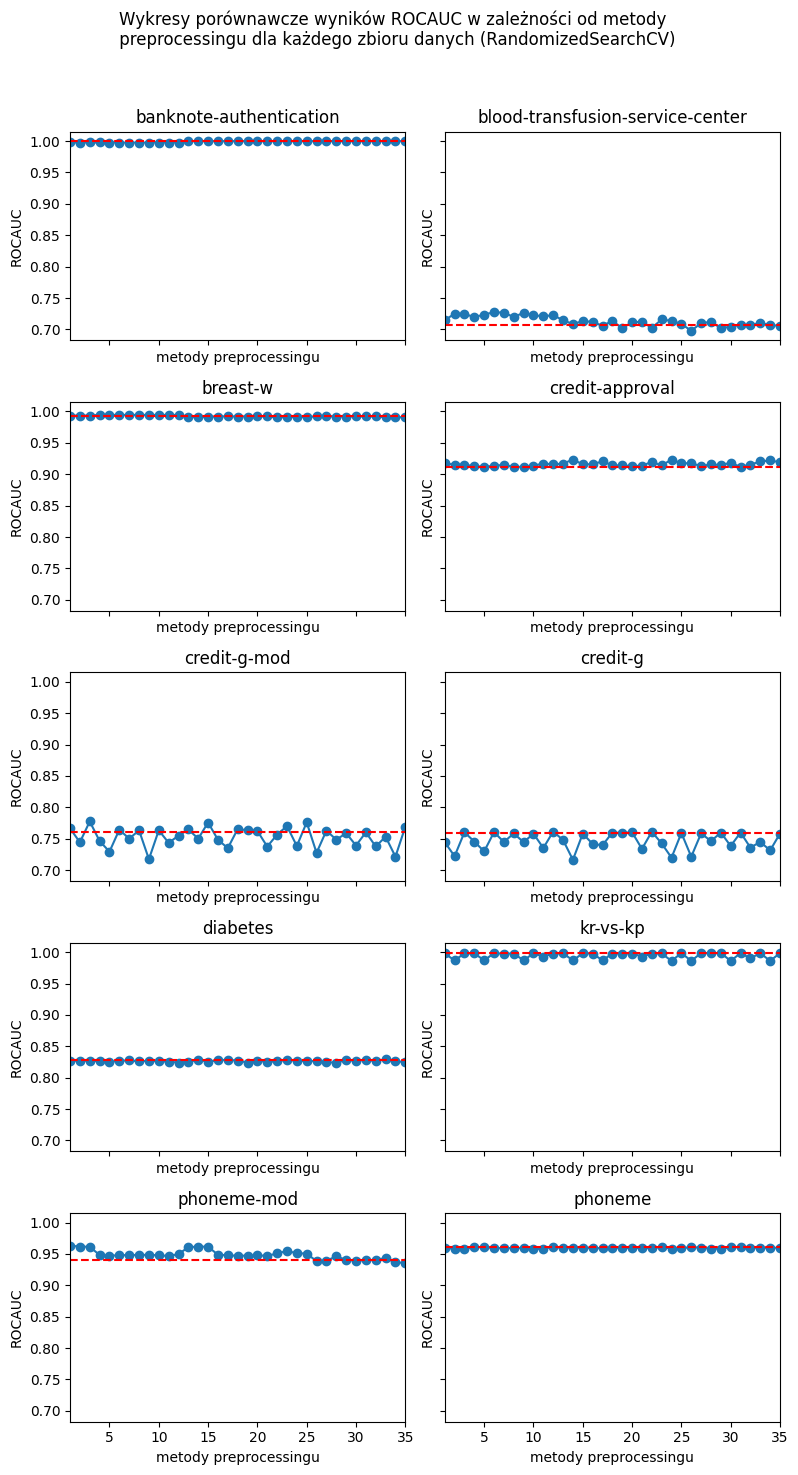

In [14]:
#RandomizedSearchCV 
fig, axes = plt.subplots(5, 2, figsize=(8, 15), sharex=True, sharey=True)
fig.suptitle("Wykresy porównawcze wyników ROCAUC w zależności od metody \n preprocessingu dla każdego zbioru danych (RandomizedSearchCV)")

for i, ax in enumerate(axes.flat):
    ax.plot(range(1, 36), mean_results.T[i+1], marker='o', linestyle='-')
    #ax.set_title(f'zbiór danych {i+1}')
    ax.set_title(names[i])
    ax.set_xlabel("metody preprocessingu")
    ax.set_ylabel("ROCAUC")
    ax.set_xlim(1, 35)
    ax.axhline(y=mean_results.T[i+1][index_basic], color='r', linestyle='--')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

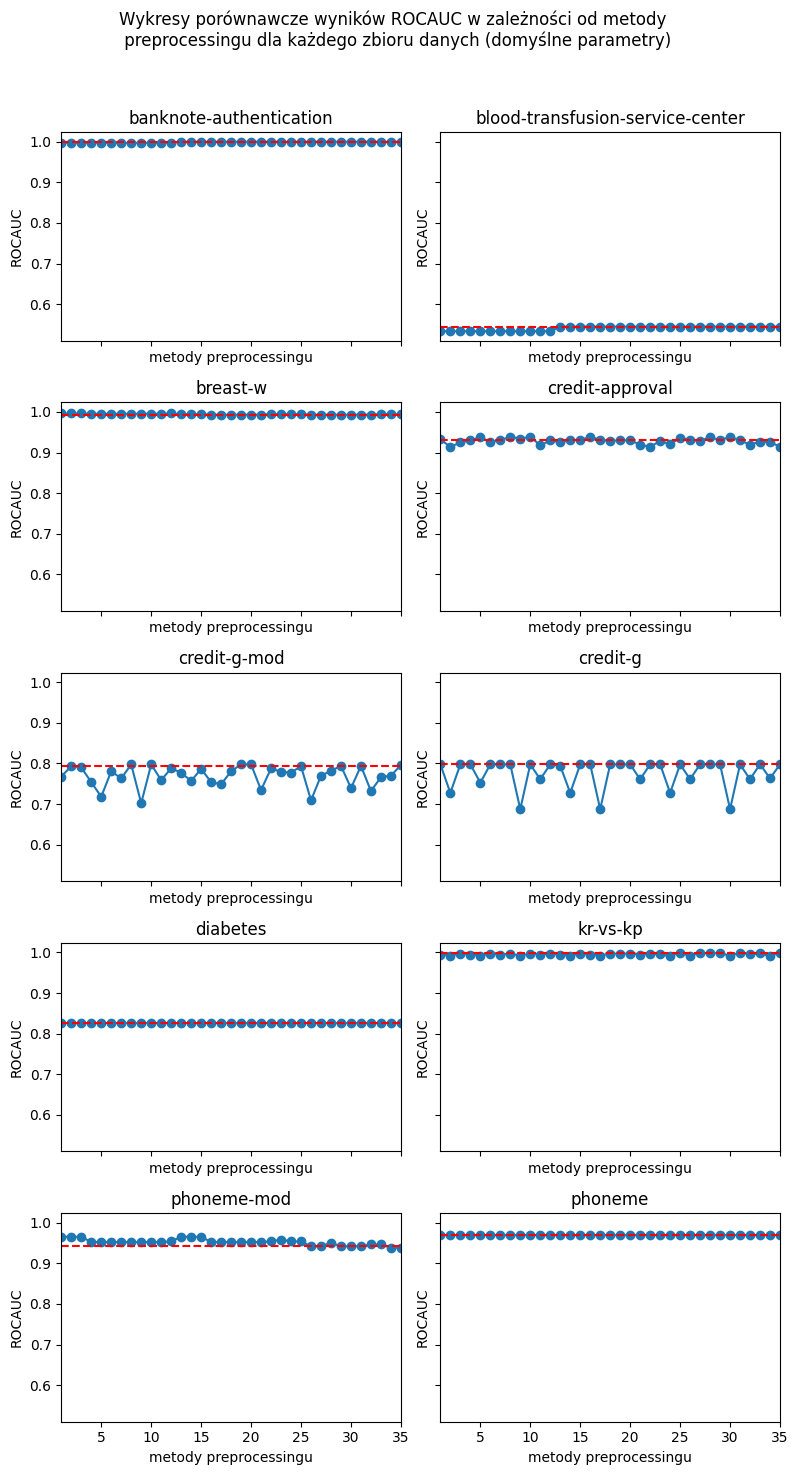

In [16]:
#default
fig, axes = plt.subplots(5, 2, figsize=(8, 15), sharex=True, sharey=True)
fig.suptitle("Wykresy porównawcze wyników ROCAUC w zależności od metody \n preprocessingu dla każdego zbioru danych (domyślne parametry)")

for i, ax in enumerate(axes.flat):
    ax.plot(range(1, 36), wynikitestmodel.T[i+1], marker='o', linestyle='-')
    ax.set_title(names[i])
    ax.set_xlabel("metody preprocessingu")
    ax.set_ylabel("ROCAUC")
    ax.set_xlim(1, 35)
    ax.axhline(y=wynikitestmodel.T[i+1][index_basic], color='r', linestyle='--')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

*Boxploty RS vs D  dla każdego zbioru, x = zbiór (RS vs D), y = ROCAUC*

*Heatmapy x = zbiór danych, y = metoda, kolor = max(ROCAUC)*

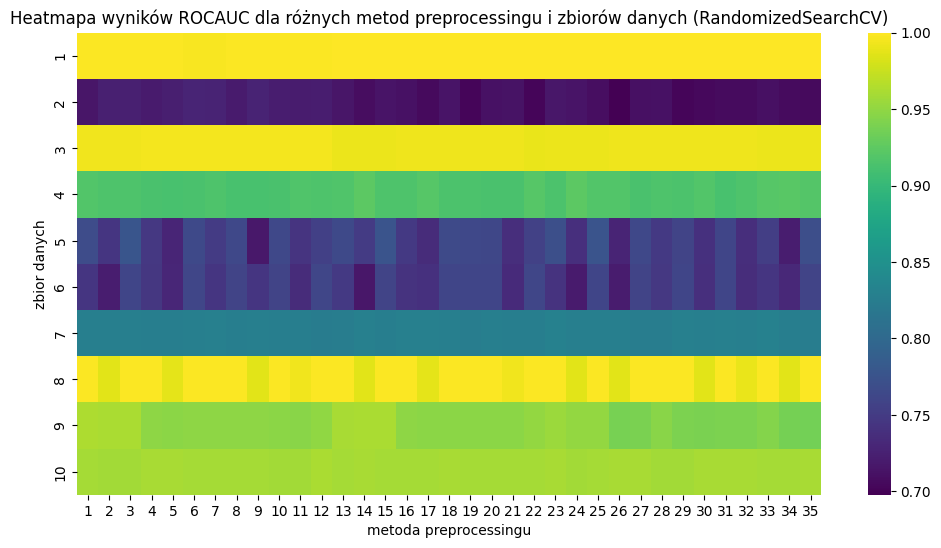

In [ ]:
#Heatmapa dla RandomizedSearchCV
plt.figure(figsize=(12, 6)) 
sns.heatmap(mean_results, cmap="viridis", annot=False, cbar=True) #można zmienić kolor
plt.xlabel("metoda preprocessingu")
plt.ylabel("zbior danych")
plt.title("Heatmapa wyników ROCAUC dla różnych metod preprocessingu i zbiorów danych (RandomizedSearchCV)")
plt.show()

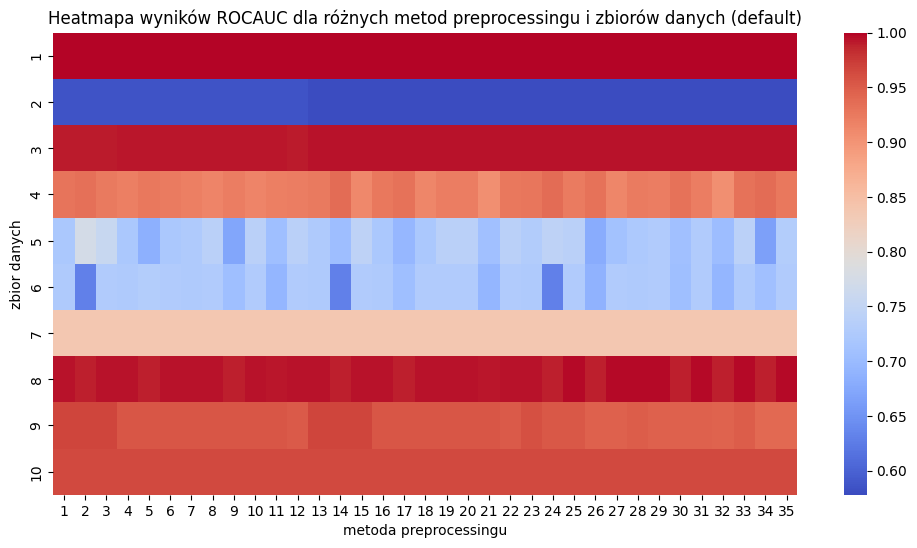

In [61]:
#Heatmapa dla default
plt.figure(figsize=(12, 6))  
sns.heatmap(wynikitestmodel, cmap="coolwarm", annot=False, cbar=True) #można zmienić kolor 
plt.xlabel("metoda preprocessingu")
plt.ylabel("zbior danych")
plt.title("Heatmapa wyników ROCAUC dla różnych metod preprocessingu i zbiorów danych (default)")
plt.show()

*Wykres y - wyniki 20 iteracji RS, x - strategia, 10 wykresow dla zbiorow*

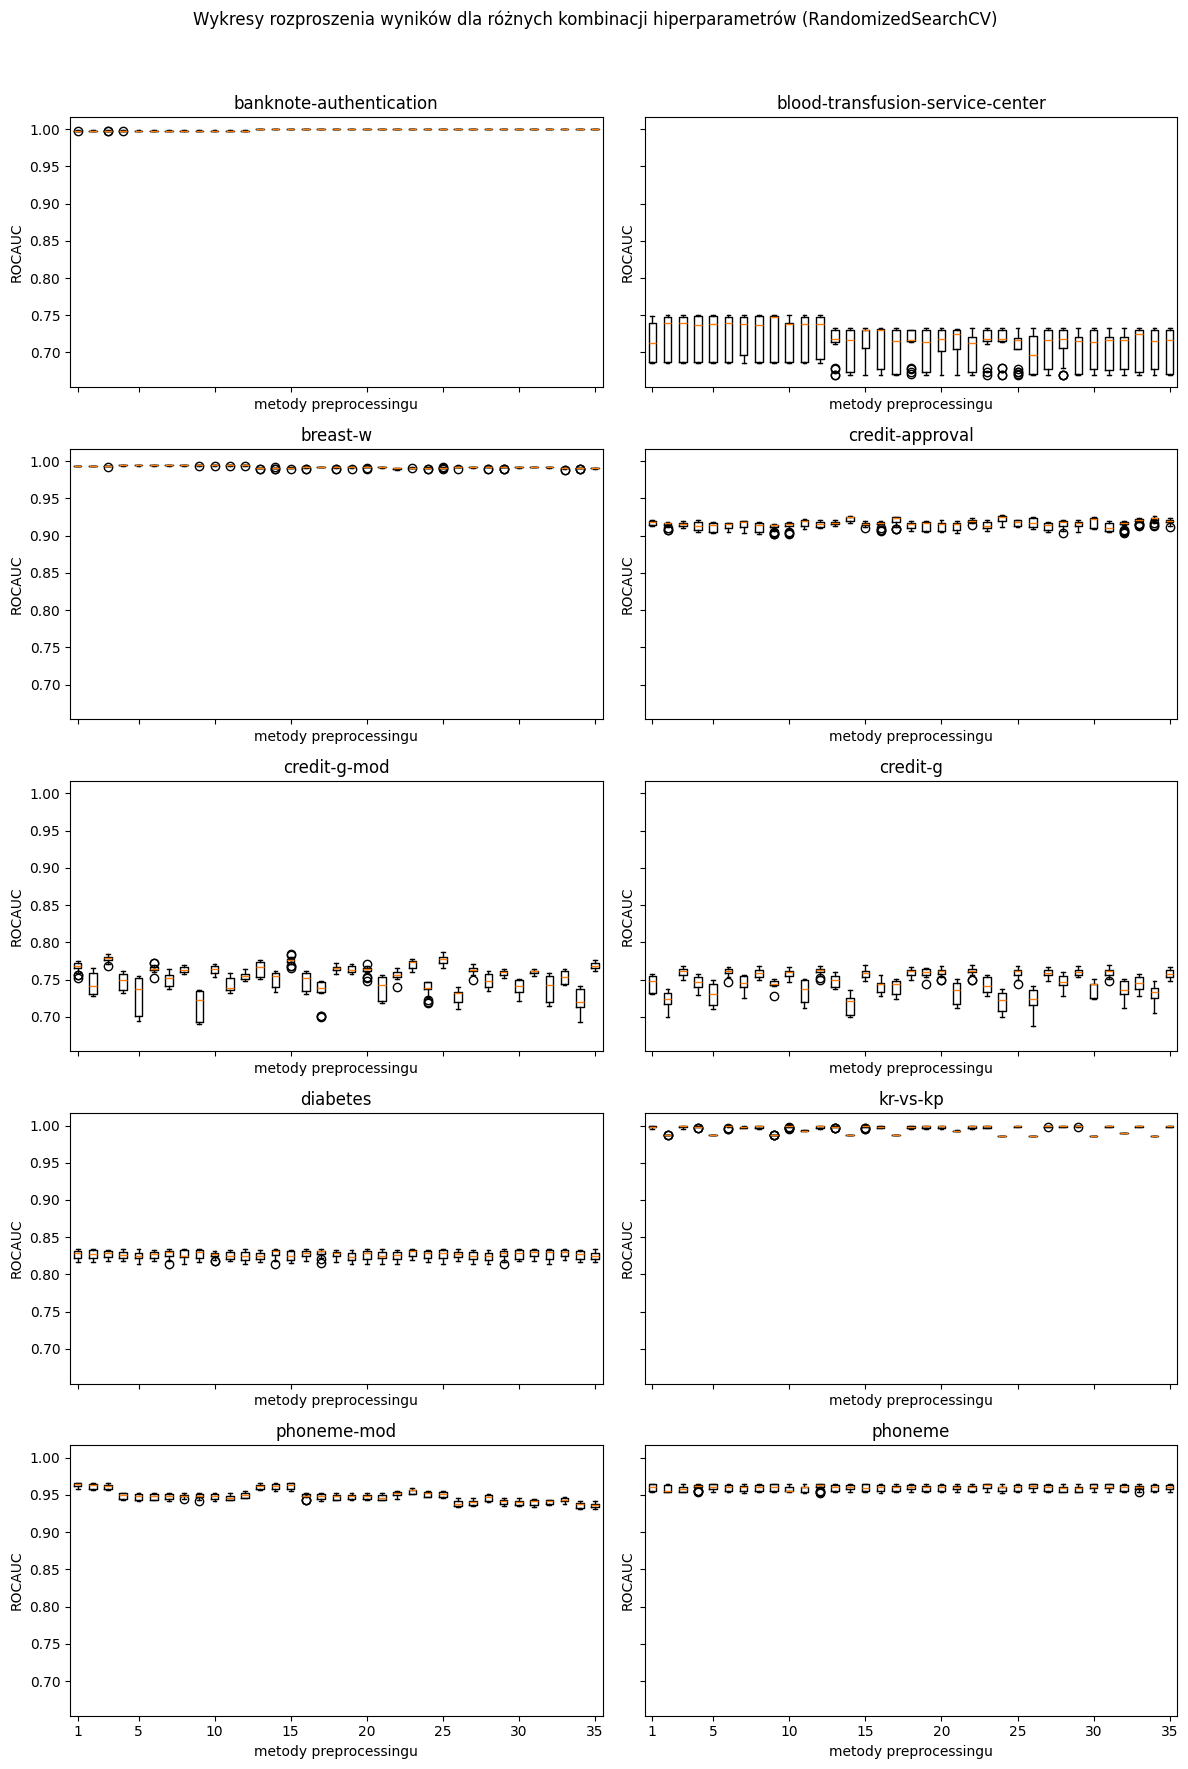

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=True, sharey=True)
fig.suptitle("Wykresy rozproszenia wyników dla różnych kombinacji hiperparametrów (RandomizedSearchCV)")

    
for i, ax in enumerate(axes.flat):
    l = []
    for j in range(35):
        l.append(np.array(wynikiRS["mean_test_score"][i*700+j*20 : i*700+j*20+20]))

    ax.boxplot(l)
    ax.set_title(names[i])
    ax.set_xlabel("metody preprocessingu")
    ax.set_ylabel("ROCAUC")
    #ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35])

plt.xticks(ticks=[1, 5, 10, 15, 20, 25, 30, 35], labels=[1, 5, 10, 15, 20, 25, 30, 35])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
#agregacja najlepszych wyników randomsearch
bestRS = [[] for _ in range(1,11)]
for i in range(10):
    for j in range(35):
        bestRS[i].append(wynikiRS["mean_test_score"][i*700+j*20 : i*700+j*20+20].max())

bestRS = pd.DataFrame(bestRS)
bestRS.to_csv("bestRS.csv", index=False) #zapisanie wyników do pliku csv

In [12]:
bestRS = pd.read_csv('bestRS.csv')
bestRS.columns = range(1,36)
bestRS.index = range(1,11) 

In [50]:
str = ""
for i in range(len(names)):
    if i != 9:
        str += f"{i+1}. " + names[i] + ", \n"
    else:
        str += f"{i+1}. " + names[i] + "."

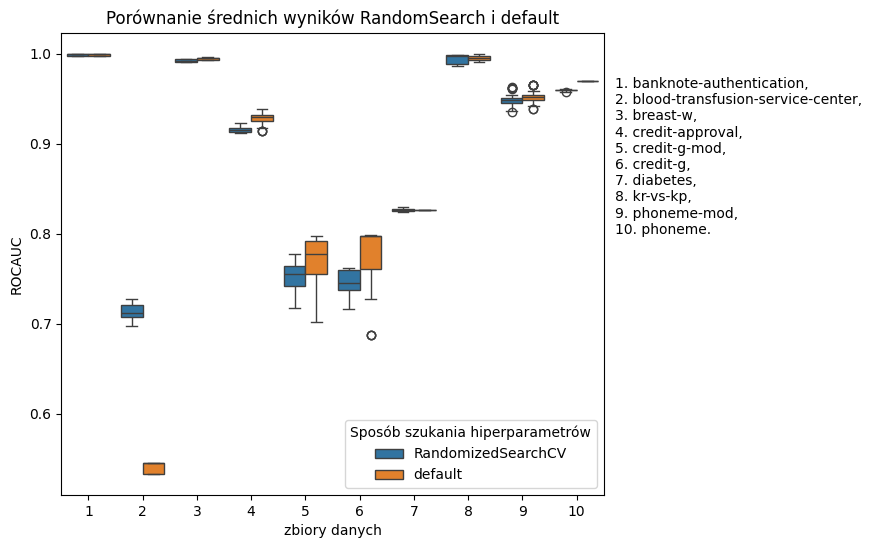

In [55]:
#Przygotowanie danych do boxplotu porównującego wyniki RandomSearch i default
df1_melted = mean_results.melt(ignore_index=False).reset_index()
df1_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df1_melted["Macierz"] = "RandomizedSearchCV"

df2_melted = wynikitestmodel.melt(ignore_index=False).reset_index()
df2_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df2_melted["Macierz"] = "default"

df_combined = pd.concat([df1_melted, df2_melted])

# Tworzenie boxplotu porównującego wartości wierszy
plt.figure(figsize=(7, 6))
fig = sns.boxplot(x="zbiór", y="ROCAUC", hue="Macierz", data=df_combined)
fig.text(9.7, 0.8, str, fontsize=10)
plt.xlabel("zbiory danych")
plt.ylabel("ROCAUC")
plt.title("Porównanie średnich wyników RandomSearch i default")
plt.legend(title="Sposób szukania hiperparametrów")
plt.show()


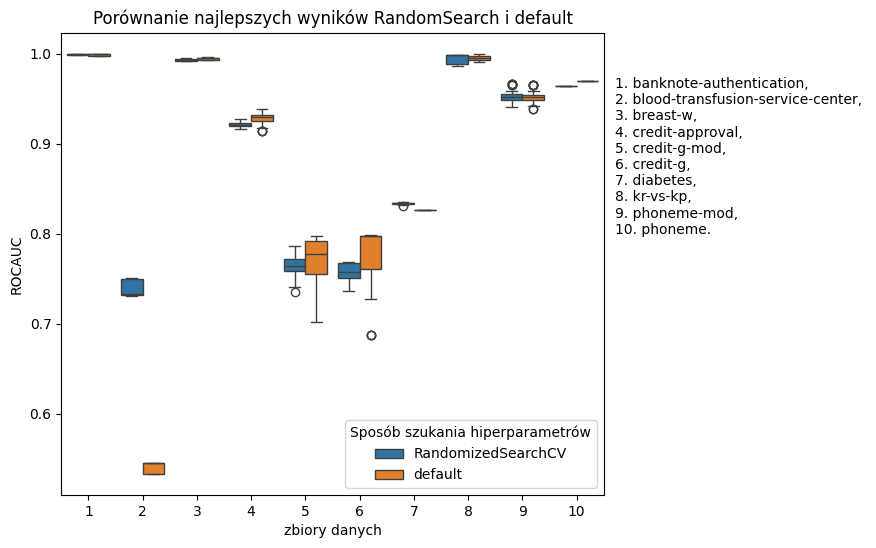

In [56]:
#porównanie wyników najlepszych hiperparametrów z RandomSearchCV i domyślnych
df1_melted = bestRS.melt(ignore_index=False).reset_index()
df1_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df1_melted["Macierz"] = "RandomizedSearchCV"

df2_melted = wynikitestmodel.melt(ignore_index=False).reset_index()
df2_melted.columns = ["zbiór", "metoda preprocessingu", "ROCAUC"]
df2_melted["Macierz"] = "default"

df_combined = pd.concat([df1_melted, df2_melted])

# Tworzenie boxplotu porównującego wartości wierszy
plt.figure(figsize=(7, 6))
fig = sns.boxplot(x="zbiór", y="ROCAUC", hue="Macierz", data=df_combined)
fig.text(9.7, 0.8, str, fontsize=10)
plt.xlabel("zbiory danych")
plt.ylabel("ROCAUC")
plt.title("Porównanie najlepszych wyników RandomSearch i default")
plt.legend(title="Sposób szukania hiperparametrów")
plt.show()
